<a href="https://colab.research.google.com/github/AbhiAadi/DeepONet/blob/main/DeeoPNet_using_Gstools_Double_Integral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gstools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 22.6 MB/s eta 0:00:00


In [2]:
from gstools import SRF, Gaussian
from gstools.random import MasterRNG
from scipy import integrate

from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.12.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
m = 100 #sampling points for discretizing functions
p = 100  #points where output is measured
n = 150  #number of different functions

In [31]:
seed = MasterRNG(20170519)
def one_function(x):
    model = Gaussian(dim=1, var=2, len_scale=1)  #increase len_scale value to get smoother curves
    srf = SRF(model, seed=seed())
    f = srf.structured([x])
    return f

In [32]:
def integrate_one_function(f):
    result = np.zeros_like(f)
    result[0] = 0
    for i in range(1, len(f)):
        result[i] = integrate.simps(f[:i+1], x[:i+1])
    return result

In [33]:
def derivative_one_function(f, x):
  return np.gradient(f, x)

In [34]:
x = np.linspace(0, 1, m)

U = np.zeros((m, n))
for i in range(m):
    U[:, i] = one_function(x)

In [35]:
S = np.zeros((m, n))
for i in range(n):
    S[:, i] =  integrate_one_function(integrate_one_function(U[:, i]))


In [25]:
# for i in range(n):
#    plt.plot(x, U[:, :i], color = 'b')
#    plt.plot(x, S[:, :i], color = 'r')
#    plt.show()

In [36]:
def interate_dataset(m=m, n=n , p=p, x=x, U=U, S=S):
    us = np.zeros((p*n, m))
    xs = np.zeros((p*n, 1))
    ss = np.zeros((p*n, 1))
    for i in range(n):
        for j in range(p):
            us[i*m+j, :] = U[:, i]
            xs[i*m+j, :] = x[j]
            ss[i*m+j, :] = S[j, i]
    return us, xs, ss

us, xs, ss = interate_dataset()
us.shape, xs.shape, ss.shape

((15000, 100), (15000, 1), (15000, 1))

In [43]:
# Dividing the dataset to Traning and Testing

ratio=0.8
train_size = int(len(us)*ratio)
us_train = us[:train_size]
xs_train = xs[:train_size]
ss_train = ss[:train_size]

us_test = us[train_size:]
xs_test = xs[train_size:]
ss_test = ss[train_size:]

us_train.shape,xs_train.shape,ss_train.shape,us_test.shape,xs_test.shape,ss_test.shape

((12000, 100), (12000, 1), (12000, 1), (3000, 100), (3000, 1), (3000, 1))

In [38]:
def deeponet_model(number_sensor_point, layer_branch, layer_trunk, nodes_branch, nodes_trunk, output_common, activation_branch, activation_trunk):
  # Creating branch net
  branch_input = tf.keras.layers.Input(shape = (number_sensor_point,), name = 'branch_input')

  branch_layers = []
  x = branch_input
  for i in range(layer_branch -1):
      layer_name = f'branch_{i+1}'
      x = tf.keras.layers.Dense(nodes_branch, activation=activation_branch, name=layer_name)(x)
      branch_layers.append(x)
  branch_output = tf.keras.layers.Dense(output_common, name = 'branch_output')(x)

  branch_net = tf.keras.models.Model(inputs = branch_input, outputs = branch_output)

  # Creating trunk net
  trunk_input = tf.keras.layers.Input(shape = (1,), name = 'trunk_input')

  trunk_layers = []
  x = trunk_input
  for i in range(layer_trunk-1):
      layer_name = f'trunk_{i+1}'
      x = tf.keras.layers.Dense(nodes_trunk, activation=activation_trunk, name=layer_name)(x)
      trunk_layers.append(x)

  trunk_output = tf.keras.layers.Dense(output_common, name = 'trunk_output')(x)

  trunk_net = tf.keras.models.Model(inputs = trunk_input, outputs = trunk_output)

  # TAKING THE OUTPUTS FROM BOTH THE ABOVE MODEL AND MULTIPLYING THEM TO TAKE IT AS A INPUT FOR FINAL MODEL
  combined_output = tf.keras.layers.Dot(axes=-1)([branch_output, trunk_output])

  # MODEL ARCHITECTURE FOR THE FINAL OUTPUT
  final_output = tf.keras.layers.Dense(1, name = 'final_output')(combined_output)
  deeponet_model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=final_output)

  return deeponet_model


In [39]:
number_sensor_point = m
layer_branch = 4
layer_trunk = 6
nodes_branch = 100
nodes_trunk = 100
output_common = 80
activation_branch = 'relu'
activation_trunk = 'relu'

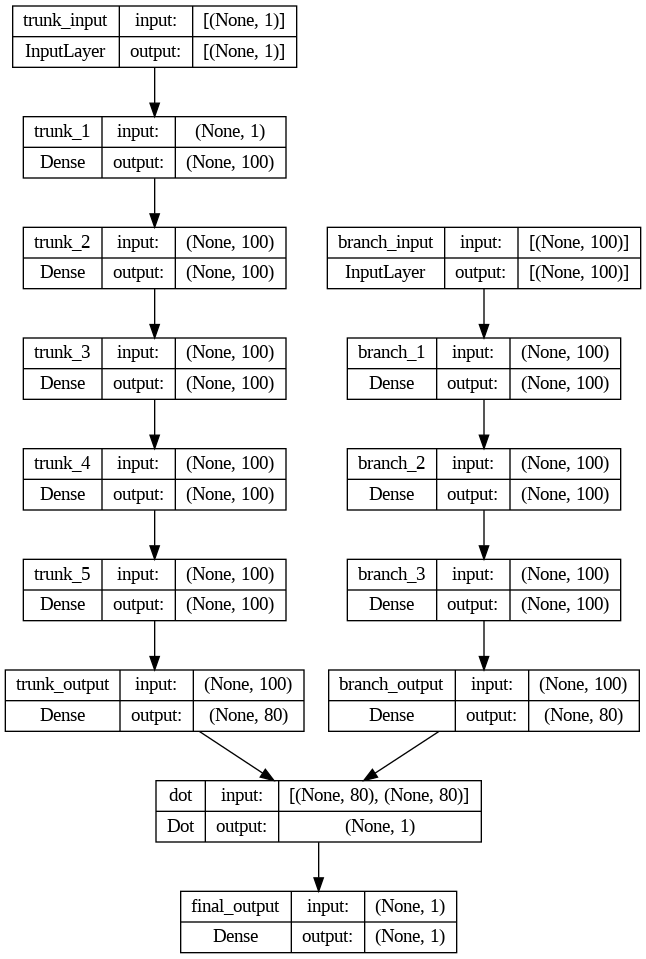

In [40]:
model = deeponet_model(number_sensor_point, layer_branch, layer_trunk, nodes_branch, nodes_trunk, output_common, activation_branch, activation_trunk)
tf.keras.utils.plot_model(model,show_shapes=True)

In [52]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 1e-4)

model.compile(optimizer = 'adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
losses = model.fit([us_train, xs_train],ss_train,epochs=100,batch_size=100,validation_data=([us_test, xs_test],ss_test))


Epoch 1/100
120/120 [==============================] - 11s 7ms/step - loss: 5.7291e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.3168e-08 - val_root_mean_squared_error: 1.1475e-04
Epoch 2/100
120/120 [==============================] - 1s 8ms/step - loss: 6.1608e-07 - root_mean_squared_error: 7.8491e-04 - val_loss: 7.0360e-09 - val_root_mean_squared_error: 8.3881e-05
Epoch 3/100
120/120 [==============================] - 1s 8ms/step - loss: 3.3751e-07 - root_mean_squared_error: 5.8096e-04 - val_loss: 7.0095e-10 - val_root_mean_squared_error: 2.6475e-05
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 7.7361e-07 - root_mean_squared_error: 8.7955e-04 - val_loss: 1.0118e-08 - val_root_mean_squared_error: 1.0059e-04
Epoch 5/100
120/120 [==============================] - 1s 5ms/step - loss: 1.7672e-06 - root_mean_squared_error: 0.0013 - val_loss: 4.9649e-09 - val_root_mean_squared_error: 7.0462e-05
Epoch 6/100
120/120 [==============================] - 1s 5ms/

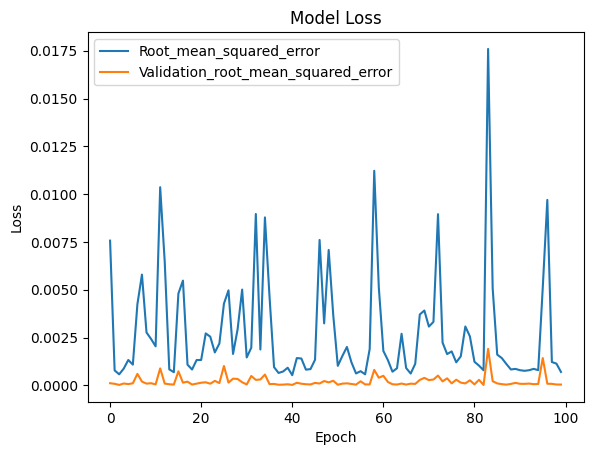

In [54]:
plt.plot(losses.history['root_mean_squared_error'], label='Root_mean_squared_error')
plt.plot(losses.history['val_root_mean_squared_error'], label='Validation_root_mean_squared_error')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

(100,)


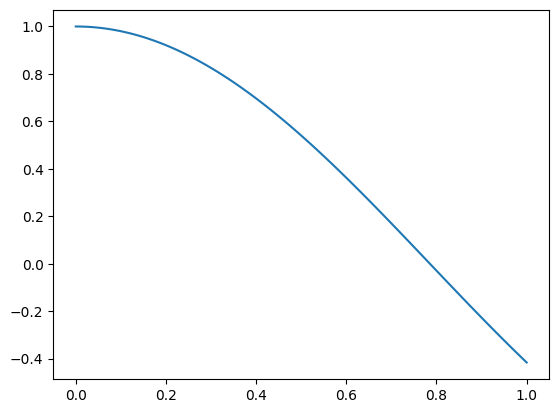

In [49]:
p =100

outp_loc = np.linspace(0,1,p)
my_func = lambda x: np.cos(2*x)
inter = lambda x: 1/2*(np.sin(x))**2
u_t = my_func(x)
s_t = inter(outp_loc)
print(u_t.shape)
plt.plot(x,u_t)
plt.show()

In [50]:
dm = []
dm1=[]
dm2=[]
for i in range(p):
  dm.append(u_t)
  j = outp_loc[i]
  dm2.append([j])
  dm1.append([s_t[i]])

inp_func = np.asarray(dm)
outp_func = np.asarray(dm1) #output function
y = np.asarray(dm2)
print(outp_func.shape)
print(y.shape)
print(inp_func.shape)

(100, 1)
(100, 1)
(100, 100)


4/4 [==============================] - 0s 3ms/step


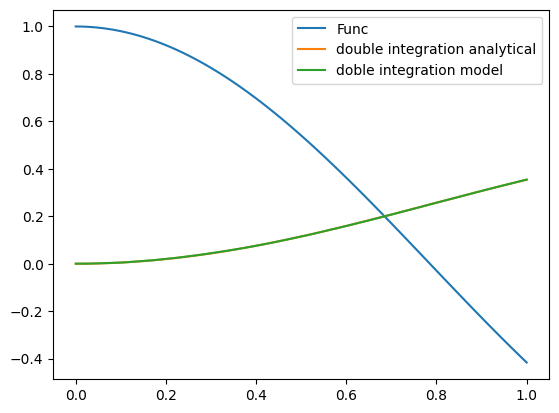

In [51]:
pt = model.predict([inp_func, y])

plt.plot(x, u_t, label="Func")
plt.plot(x, s_t, label="double integration analytical")
plt.plot(x, pt, label="doble integration model")
plt.legend();